In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

rcParams['figure.figsize'] = 6, 6

In [2]:
# importing the datasets files
rw_train  = pd.read_csv("train.csv")
rw_test   = pd.read_csv("test.csv")

rw_data   = pd.concat([rw_train, rw_test], axis =0, sort= True)
print("rw_train shape: ", rw_train.shape, " rw_test shape: ", rw_test.shape)

rw_train shape:  (252, 30)  rw_test shape:  (76, 30)


In [3]:
rw_train.head()

,Game ID,Team 1,Team 2,City,DayOfWeek,DateOfGame,TimeOfGame,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125",...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)"
0,1,Koramangala Traffic Jammers,Whitefield Water Loggers,Whitefield,1,01-01-2012,20:00:00,6,0.49,1,...,0,3,3,120.00,5,0,6,4,11,1
1,2,Electronic City Power Savers,Silkboard Slow Movers,Silkboard,2,01-02-2012,17:00:00,7,0.44,3,...,2,18,9,215.15,4,1,4,0,5,1
2,3,Indranagar Pub Watchers,Sarjapur Water Tankers,Sarjapur,3,01-03-2012,20:30:00,11,0.23,2,...,1,18,1,300.00,3,3,0,1,10,0
3,4,Bellandur Froth Fighters,Koramangala Traffic Jammers,Koramangala,4,01-04-2012,16:00:00,6,0.61,0,...,0,5,4,100.00,4,2,3,2,16,0
4,5,Marathalli Chokers,Whitefield Water Loggers,Marathalli,5,01-05-2012,20:00:00,6,0.56,3,...,3,15,6,205.26,4,2,4,1,5,0


In [4]:
rw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 30 columns):
Game ID                                                             252 non-null int64
Team 1                                                              252 non-null object
Team 2                                                              252 non-null object
City                                                                252 non-null object
DayOfWeek                                                           252 non-null int64
DateOfGame                                                          252 non-null object
TimeOfGame                                                          252 non-null object
AvgWindSpeed                                                        252 non-null int64
AvgHumidity                                                         252 non-null float64
Inn 1 Team 1 NOP R>25,SR>125                                        252 non-null int64
Inn 1 Team 1 NOP R

In [5]:
rw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 30 columns):
Game ID                                                             76 non-null int64
Team 1                                                              76 non-null object
Team 2                                                              76 non-null object
CityOfGame                                                          76 non-null object
Day                                                                 76 non-null int64
DateOfGame                                                          76 non-null object
TimeOfGame                                                          76 non-null object
AvgWindSpeed                                                        76 non-null int64
AvgHumidity                                                         76 non-null float64
Inn 1 Team 1 NOP R>25,SR>125                                        76 non-null int64
Inn 1 Team 1 NOP R<25, SR>125 

In [6]:
# columns which are missing in test set
miss_cols = [x for x in rw_train.columns if x not in rw_test.columns]
miss_cols

['City', 'DayOfWeek']

In [7]:
# Changing the name of the columns
rw_test['DayOfWeek'] = rw_test['Day']
rw_test['City']      = rw_test['CityOfGame']
rw_test = rw_test.drop(['Day', 'CityOfGame'], axis =1)

In [8]:
test = rw_test.copy()
train = rw_train.copy()

In [9]:
# again checking the missing columns
miss_cols2 = [x for x in rw_train.columns if x not in test.columns]
miss_cols2

[]

In [10]:
nuniq  = train.nunique().sort_values(ascending = False)
nuniq

Game ID                                                             252
DateOfGame                                                          252
Inn 2 Team 2 Max Strike Rate_ALLBatsmen                             144
Inn 1 Team 1 Max Strike Rate_ALLBatsmen                             121
AvgHumidity                                                          52
Inn 2 Team 2 Total 4s                                                24
Inn 1 Team 1 Total 4s                                                23
Inn 1 Team 1 Total 6s                                                18
Inn 2 Team 1 Extras conceded in_wides_No Balls                       17
Inn 1 Team 2 Extras conceded in_wides_No Balls                       17
AvgWindSpeed                                                         16
Inn 2 Team 2 Total 6s                                                15
TimeOfGame                                                           11
Inn 1 Team 2 wickets taken_catches_runout                       

In [11]:
# Getting categorical columns
cate_cols = [ x for x in train.columns if train[x].dtype == 'object']
cate_cols

['Team 1', 'Team 2', 'City', 'DateOfGame', 'TimeOfGame']

In [12]:
# Getting categorical columns
cate_cols = [ x for x in test.columns if test[x].dtype == 'object']
cate_cols

['Team 1', 'Team 2', 'DateOfGame', 'TimeOfGame', 'City']

In [13]:
train['Team 1'].unique()

array(['Koramangala Traffic Jammers', 'Electronic City Power Savers',
       'Indranagar Pub Watchers', 'Bellandur Froth Fighters',
       'Marathalli Chokers ', 'Silkboard Slow Movers',
       'Whitefield Water Loggers ', 'Sarjapur Water Tankers',
       'Airport Flyers', 'Forum Fans'], dtype=object)

In [14]:
train['Team 2'].unique()

array(['Whitefield Water Loggers ', 'Silkboard Slow Movers',
       'Sarjapur Water Tankers', 'Koramangala Traffic Jammers',
       'Indranagar Pub Watchers', 'Marathalli Chokers ',
       'Electronic City Power Savers', 'Bellandur Froth Fighters',
       'Forum Fans', 'Airport Flyers'], dtype=object)

In [15]:
# Creating a dicktionary to map the name of teams
team_map = {'Koramangala Traffic Jammers' : 'KTJ', 'Electronic City Power Savers': 'ECP',
            'Indranagar Pub Watchers' : 'IPW',
            'Bellandur Froth Fighters' : 'BFF', 'Marathalli Chokers ' : 'MC', 'Silkboard Slow Movers' :'SSM',
       'Whitefield Water Loggers ' : 'WWL', 'Sarjapur Water Tankers':'SWT', 'Airport Flyers':'AF', 'Forum Fans': 'FF'}

In [16]:
train['Team 1'] = train['Team 1'].map(team_map)  # applying the map dicktionary
train['Team 2'] = train['Team 2'].map(team_map)  # applying the map dicktionary

test['Team 1'] = test['Team 1'].map(team_map)  # applying the map dicktionary
test['Team 2'] = test['Team 2'].map(team_map)  # applying the map dicktionary

In [17]:
train['City'].unique() # for cities no need to map

array(['Whitefield', 'Silkboard', 'Sarjapur', 'Koramangala', 'Marathalli',
       'Indranagar', 'Bellandur', 'Electronic City'], dtype=object)

In [18]:
# changing the time of variable to datetime
train['DateOfGame'] = pd.to_datetime(train['DateOfGame'], format='%m-%d-%Y') 
test['DateOfGame'] = pd.to_datetime(test['DateOfGame'], format='%m-%d-%Y')

In [19]:
train['TimeOfGame'] = pd.to_datetime(train['TimeOfGame'], format= '%H:%M:%S')
test['TimeOfGame'] = pd.to_datetime(test['TimeOfGame'], format= '%H:%M:%S')

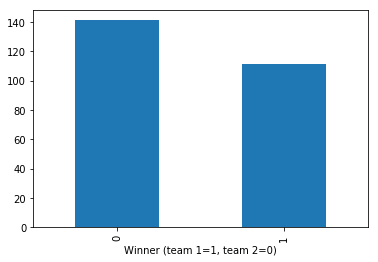

In [20]:
# checking the distribution of target column to asses the imbalanced data
train.groupby('Winner (team 1=1, team 2=0)')['Winner (team 1=1, team 2=0)'].count().plot.bar();

In [21]:
corrs = train.corr()  # Getting correlation array WRT to target column
corrs['Winner (team 1=1, team 2=0)'].sort_values(ascending=False)

Winner (team 1=1, team 2=0)                                         1.000000
Inn 2 Team 1 wickets taken_catches_runout                           0.708980
Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping    0.541472
Inn 1 Team 1 Total 6s                                               0.406786
Inn 1 Team 1 NOP R>25,SR>125                                        0.406192
Inn 1 Team 1 Total 4s                                               0.319904
Inn 2 Team 2 NOP R<25, SR>125                                       0.294260
Inn 1 Team 1 Max Strike Rate_ALLBatsmen                             0.221178
Inn 1 Team 1 NOP R<25, SR>125                                       0.148474
Inn 1 Team 2 NoP fast bowlers                                       0.082600
Inn 1 Team 2 NoP Spinners                                           0.076123
Inn 2 Team 1 NoP fast bowlers                                       0.048978
Game ID                                                             0.044227

In [22]:
dropped_cols = ['Game ID', 'DateOfGame', 'TimeOfGame'] # dropping the irrelevant columns

In [23]:
train = train.drop(dropped_cols, axis=1)
test  = test.drop(dropped_cols, axis=1)
contri_cols = train.columns
print("Train shape:", train.shape, "Test shape: ", test.shape)

Train shape: (252, 27) Test shape:  (76, 27)


In [ ]:
corr2 = train.corr()
corr2['Winner (team 1=1, team 2=0)'].sort_values(ascending=False)

In [24]:
#Dealing with categorical columns
cate_cols  = [ x for x in test.columns if test[x].dtype == 'object']

# creating the dummy columns to handel categorical values
dummy_df = pd.get_dummies(train[cate_cols])
train = pd.concat([train, dummy_df], axis=1)
train = train.drop(cate_cols, axis=1)

#  same as for test dataset
dummyTest_df = pd.get_dummies(test[cate_cols])
test = pd.concat([test, dummyTest_df], axis =1)
test = test.drop(cate_cols, axis=1)

print("Train shape:", train.shape, "Test shape: ", test.shape)

Train shape: (252, 52) Test shape:  (76, 49)


In [25]:
cate_cols

['Team 1', 'Team 2', 'City']

In [26]:
miss_cols3 = [x for x in train.columns if x not in test.columns]
miss_cols3

['Team 1_AF', 'Team 1_FF', 'Team 2_AF', 'Team 2_FF']

In [27]:
miss_cols4 = [x for x in test.columns if x not in train.columns]
miss_cols4

['City_HSR']

In [28]:
miss_team = [x for x in rw_train['Team 1'].values if x not in rw_test['Team 1'].values]
miss_team

['Airport Flyers',
 'Airport Flyers',
 'Forum Fans',
 'Forum Fans',
 'Airport Flyers',
 'Airport Flyers',
 'Forum Fans',
 'Forum Fans',
 'Airport Flyers',
 'Airport Flyers',
 'Airport Flyers',
 'Forum Fans',
 'Forum Fans']

In [31]:
train2 = train.drop(miss_cols3, axis=1)
test2  = test.drop(miss_cols4, axis=1)
print("Train shape:", train2.shape, "Test shape: ", test2.shape)

Train shape: (252, 48) Test shape:  (76, 48)


In [ ]:
train.head()

In [32]:
# Extra imports necessary for the code

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        self.thresh = thresh
        

        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=4.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [34]:
# defining X and Y for the process

X = train2.drop(['Winner (team 1=1, team 2=0)'], axis =1)
Y = train2['Winner (team 1=1, team 2=0)']

X.shape

(252, 47)

In [35]:
# Geting rid of highly correlate columns
transformer = ReduceVIF()

X = transformer.fit_transform(X, Y)

X.head()

C:\Users\amar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


ReduceVIF fit
ReduceVIF transform
Dropping City_Marathalli with vif=38.70539771217243
Dropping Inn 1 Team 2 NoP fast bowlers with vif=45.39886545746083
Dropping Inn 2 Team 1 NoP fast bowlers with vif=31.552326601962577
Dropping Inn 1 Team 1 Total 4s with vif=27.64209954659538
Dropping Inn 2 Team 2 Max Strike Rate_ALLBatsmen with vif=24.02738249268167
Dropping AvgHumidity with vif=20.249135773231004
Dropping Inn 2 Team 2 Total 4s with vif=17.984985548216525
Dropping Inn 1 Team 1 Max Strike Rate_ALLBatsmen with vif=14.52091576362382
Dropping AvgWindSpeed with vif=12.592833748408744
Dropping Inn 1 Team 2 NoP Spinners with vif=9.347069842049372
Dropping Inn 2 Team 2 Total 6s with vif=8.715425588913616
Dropping Inn 2 Team 1 NoP Spinners with vif=7.776232529126963
Dropping Inn 1 Team 2 wickets taken_catches_runout with vif=7.021193469719947
Dropping Inn 1 Team 1 Total 6s with vif=6.897195062048182
Dropping Inn 1 Team 1 NOP R>25,SR>125 with vif=5.438723661450816
Dropping DayOfWeek with vif=5.

,"Inn 1 Team 1 NOP R<25, SR>125",Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 1 Team 2 Extras conceded in_wides_No Balls,"Inn 2 Team 2 NOP R>25,SR>125","Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,Team 1_BFF,Team 1_ECP,...,Team 2_SSM,Team 2_SWT,Team 2_WWL,City_Bellandur,City_Electronic City,City_Indranagar,City_Koramangala,City_Sarjapur,City_Silkboard,City_Whitefield
0,1.0,0.0,9.0,0.0,0.0,6.0,4.0,11.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,4.0,4.0,2.0,2.0,4.0,0.0,5.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,4.0,3.0,2.0,1.0,0.0,1.0,10.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,3.0,6.0,0.0,0.0,3.0,2.0,16.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,2.0,3.0,1.0,3.0,4.0,1.0,5.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42,shuffle = True)

In [37]:
cat = RandomForestClassifier(n_estimators=60)
cat.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
pred2 = cat.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(pred2,y_test))

0.8712871287128713


In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 6, 11, 16, 21, 26, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [41]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [42]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.9s finished
C:\Users\amar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 6, 11, 16, 21, 26, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [43]:
best_random = rf_random.best_estimator_
preds = best_random.predict(X_test)
print(accuracy_score(preds,y_test))

0.900990099009901


In [44]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 35,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 70}

In [45]:
# BCS the data observation are very less so we will use the logisticRegression
from sklearn.linear_model import LogisticRegression


In [46]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\amar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
pred = lr.predict(X_test)
print(accuracy_score(pred,y_test))

0.8910891089108911


In [48]:
t_act  = test['Winner (team 1=1, team 2=0)']
f_test = test[X.columns]

In [49]:
t_pred = lr.predict(f_test)
print(accuracy_score(t_pred,t_act))

0.868421052631579
